In [1]:
from math import sqrt,ceil, floor


In [2]:
import numpy as np
def arbre_recomb(n,b): #arbre avec recombinaison sous forme de tableau
    l=2*b*n+1
    S=np.zeros((l,n+1))
    for i in range(1,n+1):
        for j in range(l):
            if j<b*n :
                for k in range(b*(n-i),b*n):
                    S[k,i]=b*n-k
            if j>b*n:
                S[j,i]=-S[2*b*n-j,i]
    return S

In [3]:
def arbre_recomb2(n,b):
    l=2*b*n+1
    S=np.zeros((l,n+1))
    for i in range(l):
        S[i,n]= b*n-i
    for j in range(1,n+1):
        for i in  range(l):
            if i>=b*j and i<=b*(2*n-j):
                S[i,n-j]=b*n-i
    return S


In [4]:
arbre_recomb2(1000,5)

array([[    0.,     0.,     0., ...,     0.,     0.,  5000.],
       [    0.,     0.,     0., ...,     0.,     0.,  4999.],
       [    0.,     0.,     0., ...,     0.,     0.,  4998.],
       ...,
       [    0.,     0.,     0., ...,     0.,     0., -4998.],
       [    0.,     0.,     0., ...,     0.,     0., -4999.],
       [    0.,     0.,     0., ...,     0.,     0., -5000.]])

In [5]:
def proba_up_middle_down(List_sigma,List_a,Liste_saut,sigma_bar,T,n):
    proba=np.zeros((3,len(List_sigma)))
    h=T/n
    for i in range(len(List_sigma)):
        proba[0,i]=(List_sigma[i]**2+List_a[i]*Liste_saut[i]*sigma_bar*np.sqrt(h)+h*List_a[i]**2)/(2*(Liste_saut[i]*sigma_bar)**2)
        proba[1,i]=(List_sigma[i]**2-List_a[i]*Liste_saut[i]*sigma_bar*np.sqrt(h)+h*List_a[i]**2)/(2*(Liste_saut[i]*sigma_bar)**2)
        proba[2,i]=1-(proba[0,i]+proba[1,i])
    return proba

In [6]:
arbre=arbre_recomb2(1000,5)

In [7]:
kappa = 3.0
theta = 0.04
sigma_v = 0.1
r = 0.05
rho = -0.1 # covariance between price and volatility brownian motions
v0 = 0.04
sigma_bar = 0.1

In [8]:
def prix_call_europeen(K,S_o,n,b,sigma_bar,T,List_sigma,List_a,Liste_saut,List_r,P):
    proba_umd=proba_up_middle_down(List_sigma,List_a,Liste_saut,sigma_bar,T,n)
    l=2*b*n+1
    h=T/n
    table_prix=np.zeros((l,n+1),dtype=object)
    for i in range(l):
        table_prix[i,n]={reg:max(-K+S_o*np.exp(arbre[i,n]*sigma_bar*np.sqrt(h)),0) for reg in range(len(List_sigma))}
    for j in range(1,n+1):
        for i in range(l):
            if i>=b*j and i<=b*(2*n-j):
                table_prix[i,n-j]={reg:0 for reg in range(len(List_sigma))}
                for etat in range(len(List_sigma)):
                    r=List_r[etat]
                    saut=Liste_saut[etat]
                    for k in range(len(List_sigma)):
                        table_prix[i,n-j][etat] += P[etat,k]*(table_prix[i-saut,n-j+1][k]*proba_umd[0,etat]+table_prix[i+saut,n-j+1][k]*proba_umd[1,etat]+table_prix[i,n-j+1][k]*proba_umd[2,etat])
                    table_prix[i,n-j][etat]=np.exp(-r*h)*table_prix[i,n-j][etat]
        
    return table_prix

In [9]:
dw = 0.02

In [10]:
ml, mu=  15, 40
m = mu-ml+1
regimes = range(m)

In [11]:
# Compute the Markov chain

# upper and lower bounds for the discretization of the volatility


def transition(k):

    forward = sigma_v**2/(2*(dw)**2) + (2*kappa*theta-sigma_v**2)/(2*k*(dw)**2) - kappa*k/4

    backward = sigma_v**2/(2*(dw)**2) - (2*kappa*theta-sigma_v**2)/(2*k*(dw)**2) + kappa*k/4

    return forward,backward


def transition(k):

    forward = sigma_v**2/(2*(dw)**2) + (2*kappa*theta-(sigma_v**2)/2)/(2*k*(dw)**2) - kappa*k/4

    backward = sigma_v**2/(2*(dw)**2) - (2*kappa*theta-(sigma_v**2)/2)/(2*k*(dw)**2) + kappa*k/4

    return forward,backward


def compute_Q():
    
    Q = np.zeros((m,m))

    for i in range(1,m-1):
        
        forward,backward = transition(i+ml-1)

        if forward>=0 and backward>=0:

            Q[i,i+1] = forward
            Q[i,i-1] = backward
            Q[i,i] = -(forward+backward)

        elif forward>0:

            Q[i,i-1] = backward + kappa*(i+ml-1)/4
            Q[i,i+1] = sigma_v**2/(2*(dw)**2) 
            Q[i,i] = -forward-backward

        else:
            
            Q[i,i-1] = sigma_v**2/(2*(dw)**2) 
            Q[i,i+1] = forward - kappa*(i+ml-1)/4
            Q[i,i] = -forward-backward
    # i =0
    Q[0,1] = (2*kappa*theta-(sigma_v**2)/2)/(ml*(dw)**2) - kappa*ml/2
    Q[0,0] = - Q[0,1]
    # i = m-1
    Q[m-1,m-2] = -(2*kappa*theta-(sigma_v**2)/2)/(mu*(dw)**2) + kappa*mu/2
    Q[m-1,m-1] = - Q[m-1,m-2]

    return Q

In [12]:
def transition_matrix(Q,h):
    nbr=Q.shape[0]
    tr_matrix=np.zeros((nbr,nbr))
    for i in range(nbr):
        for j in range(nbr):
            if i==j:
                tr_matrix[i,j]=np.exp(Q[i,j]*h)
            else:
                tr_matrix[i,j]=-(1-np.exp(Q[i,i]*h))*Q[i,j]/Q[i,i]
    tr_matrix = np.nan_to_num(tr_matrix, nan=0)
    return tr_matrix


In [13]:
Q=np.array([[-0.5,0.5],[0.5,-0.5]])
P=transition_matrix(Q,1/1000)

In [14]:
Q1=compute_Q()
P1=transition_matrix(Q1,0.25/2500)

In [15]:
P1

array([[ 9.98334721e-01,  1.66527855e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 4.16146267e-04,  9.97503122e-01,  2.08073134e-03,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00

In [24]:
L1=[0.15,0.25]
L2=[0.05-0.5*0.15**2 ,0.05-0.5*0.25**2 ]
L3=[1,2]
L4=[0.05,0.05]

In [17]:
def liste_saut(nbr_reg,liste_sigma,liste_a):
    liste_saut = [0]*nbr_reg
    for i in range (nbr_reg):
        k1,k2 = floor(2*liste_sigma[i]/sigma_bar),ceil(2*liste_sigma[i]/sigma_bar)
        if k1==k2 or k1*sigma_bar<liste_sigma[i]:
            liste_saut[i] = k2
        else:
            c = ((k1*sigma_bar)**2-liste_sigma[i]**2)/liste_a[i]**2
            d = (k2*sigma_bar-sqrt((k2*sigma_bar)**2-4*liste_sigma[i]**2))**2/(4*liste_a[i])**2
            if c<=d:
                liste_saut[i] = k2
            else:
                liste_saut[i] = k1
    return liste_saut

In [18]:
L5=liste_saut(2,L1,L2)

In [19]:
L5

[2, 5]

In [20]:
list_vi = [(1/4)*((i+ml-1)*dw)**2 for i in range(1,m+1)]
list_sigma = [np.sqrt(list_vi[i]*(1-rho**2)) for i in range(len(list_vi))]
list_a = [list_vi[i]*((rho*kappa/sigma_v)-0.5) for i in range(len(list_vi))]

list_saut = [0]*m
for i in range (m):
    k1,k2 = floor(2*list_sigma[i]/sigma_bar),ceil(2*list_sigma[i]/sigma_bar)
    if k1==k2 or k1*sigma_bar<list_sigma[i]:
        list_saut[i] = k2
    else:
        c = ((k1*sigma_bar)**2-list_sigma[i]**2)/list_a[i]**2
        d = (k2*sigma_bar-sqrt((k2*sigma_bar)**2-4*list_sigma[i]**2))**2/(4*list_a[i])**2
        if c<=d:
            list_saut[i] = k2
        else:
            list_saut[i] = k1

list_r = [0.05]*m

In [21]:
proba_up_middle_down(L1,L2,L5,0.1,1,1000)

array([[0.2811512 , 0.12432892],
       [0.28134884, 0.12567289],
       [0.43749996, 0.74999819]])

In [22]:
A1=prix_call_europeen(100,90,1000,5,0.1,1,L1,L2,L5,L4,P)

In [23]:
A1[:,0][1000*5]

{0: 2.788273482533414, 1: 4.805571421550553}

In [30]:
A1=prix_call_europeen(100,94,1000,2,0.2,1,L1,L2,L3,L4,P)
A2=prix_call_europeen(100,96,1000,2,0.2,1,L1,L2,L3,L4,P)
A3=prix_call_europeen(100,98,1000,2,0.2,1,L1,L2,L3,L4,P)
A4=prix_call_europeen(100,100,1000,2,0.2,1,L1,L2,L3,L4,P)
A5=prix_call_europeen(100,102,1000,2,0.2,1,L1,L2,L3,L4,P)
A6=prix_call_europeen(100,104,1000,2,0.2,1,L1,L2,L3,L4,P)
A7=prix_call_europeen(100,106,1000,2,0.2,1,L1,L2,L3,L4,P)

In [31]:
A = [A1, A2, A3, A4, A5, A6, A7]

In [32]:
import pandas as pd
Df1 = pd.DataFrame({'S0':[i for i in range(94,107,2)], 'Tree':[B[:,0][2000] for B in A]})
Df1

,S0,Tree
0,94,"{0: 5.86121169713768, 1: 8.228404386030418}"
1,96,"{0: 6.923020326921834, 1: 9.317382007445124}"
2,98,"{0: 8.083383992632376, 1: 10.477573544944184}"
3,100,"{0: 9.338299622468098, 1: 11.704247134436248}"
4,102,"{0: 10.683620427004527, 1: 13.000574946330795}"
5,104,"{0: 12.111348355527737, 1: 14.356138588476941}"
6,106,"{0: 13.61462223374124, 1: 15.772456149244976}"


In [23]:
def prix_put_europeen(K,S_o,n,b,sigma_bar,T,List_sigma,List_a,Liste_saut,List_r,P):
    proba_umd=proba_up_middle_down(List_sigma,List_a,Liste_saut,sigma_bar,T,n)
    l=2*b*n+1
    h=T/n
    table_prix=np.zeros((l,n+1),dtype=object)
    for i in range(l):
        table_prix[i,n]={reg:max(K-S_o*np.exp(arbre[i,n]*sigma_bar*np.sqrt(h)),0) for reg in range(len(List_sigma))}
    for j in range(1,n+1):
        for i in range(l):
            if i>=b*j and i<=b*(2*n-j):
                table_prix[i,n-j]={reg:0 for reg in range(len(List_sigma))}
                for etat in range(len(List_sigma)):
                    r=List_r[etat]
                    saut=Liste_saut[etat]
                    for k in range(len(List_sigma)):
                        table_prix[i,n-j][etat] += P[etat,k]*(table_prix[i-saut,n-j+1][k]*proba_umd[0,etat]+table_prix[i+saut,n-j+1][k]*proba_umd[1,etat]+table_prix[i,n-j+1][k]*proba_umd[2,etat])
                    table_prix[i,n-j][etat]=np.exp(-r*h)*table_prix[i,n-j][etat]
        
    return table_prix

In [24]:
def prix_call_americain(K,S_o,n,b,sigma_bar,T,List_sigma,List_a,Liste_saut,List_r,P):
    proba_umd=proba_up_middle_down(List_sigma,List_a,Liste_saut,sigma_bar,T,n)
    l=2*b*n+1
    h=T/n
    table_prix=np.zeros((l,n+1),dtype=object)
    for i in range(l):
        table_prix[i,n]={reg:max(-K+S_o*np.exp(arbre[i,n]*sigma_bar*np.sqrt(h)),0) for reg in range(len(List_sigma))}
    for j in range(1,n+1):
        for i in range(l):
            if i>=b*j and i<=b*(2*n-j):
                table_prix[i,n-j]={reg:0 for reg in range(len(List_sigma))}
                for etat in range(len(List_sigma)):
                    r=List_r[etat]
                    saut=Liste_saut[etat]
                    for k in range(len(List_sigma)):
                        table_prix[i,n-j][etat] += P[etat,k]*(table_prix[i-saut,n-j+1][k]*proba_umd[0,etat]+table_prix[i+saut,n-j+1][k]*proba_umd[1,etat]+table_prix[i,n-j+1][k]*proba_umd[2,etat])
                    table_prix[i,n-j][etat]=np.exp(-r*h)*table_prix[i,n-j][etat]
                    table_prix[i,n-j][etat]=max(table_prix[i,n-j][etat],-K+S_o*np.exp(arbre[i,n-j]*sigma_bar*np.sqrt(h)))
        
    return table_prix

In [25]:
def prix_put_americain(K,S_o,n,b,sigma_bar,T,List_sigma,List_a,Liste_saut,List_r,P):
    proba_umd=proba_up_middle_down(List_sigma,List_a,Liste_saut,sigma_bar,T,n)
    l=2*b*n+1
    h=T/n
    table_prix=np.zeros((l,n+1),dtype=object)
    for i in range(l):
        table_prix[i,n]={reg:max(K-S_o*np.exp(arbre[i,n]*sigma_bar*np.sqrt(h)),0) for reg in range(len(List_sigma))}
    for j in range(1,n+1):
        for i in range(l):
            if i>=b*j and i<=b*(2*n-j):
                table_prix[i,n-j]={reg:0 for reg in range(len(List_sigma))}
                for etat in range(len(List_sigma)):
                    r=List_r[etat]
                    saut=Liste_saut[etat]
                    for k in range(len(List_sigma)):
                        table_prix[i,n-j][etat] += P[etat,k]*(table_prix[i-saut,n-j+1][k]*proba_umd[0,etat]+table_prix[i+saut,n-j+1][k]*proba_umd[1,etat]+table_prix[i,n-j+1][k]*proba_umd[2,etat])
                    table_prix[i,n-j][etat]=np.exp(-r*h)*table_prix[i,n-j][etat]
                    table_prix[i,n-j][etat]=max(table_prix[i,n-j][etat],K-S_o*np.exp(arbre[i,n-j]*sigma_bar*np.sqrt(h)))
        
    return table_prix

In [25]:
C1=prix_put_americain(100,94,1000,2,0.2,1,L1,L2,L3,L4,P)
C2=prix_put_americain(100,96,1000,2,0.2,1,L1,L2,L3,L4,P)
C3=prix_put_americain(100,98,1000,2,0.2,1,L1,L2,L3,L4,P)
C4=prix_put_americain(100,100,1000,2,0.2,1,L1,L2,L3,L4,P)
C5=prix_put_americain(100,102,1000,2,0.2,1,L1,L2,L3,L4,P)
C6=prix_put_americain(100,104,1000,2,0.2,1,L1,L2,L3,L4,P)
C7=prix_put_americain(100,106,1000,2,0.2,1,L1,L2,L3,L4,P)

In [26]:
C=[C1, C2, C3, C4, C5, C6, C7]

In [29]:
Df2 = pd.DataFrame({'S0':[i for i in range(94,107,2)], 'Tree':[B[:,0][2000] for B in C]})
Df2

,S0,Tree
0,94,"{0: 7.887341803269553, 1: 10.246044855314704}"
1,96,"{0: 6.761619788250978, 1: 9.211130469447333}"
2,98,"{0: 5.77279975983544, 1: 8.263628289981797}"
3,100,"{0: 4.909105962224006, 1: 7.397754729040091}"
4,102,"{0: 4.15974578321561, 1: 6.6126611028022015}"
5,104,"{0: 3.5125898797011983, 1: 5.898792664675986}"
6,106,"{0: 2.9567023364071985, 1: 5.254773500702386}"


In [26]:
def prix_call_europeen_Heston_model(K,S_o,n,b,sigma_bar,T,List_vi,List_sigma,List_a,Liste_saut,List_r,P):
    proba_umd=proba_up_middle_down(List_sigma,List_a,Liste_saut,sigma_bar,T,n)
    l=2*b*n+1
    h=T/n
    table_prix=np.zeros((l,n+1),dtype=object)
    for i in range(l):
        table_prix[i,n]={reg:max(-K+S_o*np.exp((arbre[i,n])*sigma_bar*np.sqrt(h)+(rho/sigma_v)*(List_vi[reg]-v0)+(0.05-rho*kappa*theta/sigma_v)*n*h),0) for reg in range(len(List_sigma))}
    for j in range(1,n+1):
        for i in range(l):
            if i>=b*j and i<=b*(2*n-j):
                table_prix[i,n-j]={reg:0 for reg in range(len(List_sigma))}
                for etat in range(len(List_sigma)):
                    r=List_r[etat]
                    saut=Liste_saut[etat]
                    for k in range(len(List_sigma)):
                        table_prix[i,n-j][etat] += P[etat,k]*(table_prix[i-saut,n-j+1][k]*proba_umd[0,etat]+table_prix[i+saut,n-j+1][k]*proba_umd[1,etat]+table_prix[i,n-j+1][k]*proba_umd[2,etat])
                    table_prix[i,n-j][etat]=np.exp(-r*h)*table_prix[i,n-j][etat]
        
    return table_prix

In [26]:
r=0.05
B=prix_call_europeen_Heston_model(100,90,2500,3,0.2,0.25,list_vi,list_sigma,list_a,list_saut,list_r,P1)

IndexError: index 2500 is out of bounds for axis 1 with size 1001

In [ ]:
B[:,0][2500*3]

In [27]:
def prix_call_europeen2(K,S_o,n,b,sigma_bar,T,List_sigma,List_a,Liste_saut,List_r,P):
    proba_umd=proba_up_middle_down(List_sigma,List_a,Liste_saut,sigma_bar,T,n)
    l=2*b*n+1
    h=T/n
    table_prix=np.zeros((l,n+1,len(List_sigma)))
    for i in range(l):
        for reg in range(len(List_sigma)):
            table_prix[i,n,reg]=max(-K+S_o*np.exp(arbre[i,n]*sigma_bar*np.sqrt(h)),0)
    for j in range(1,n+1):
        for i in range(l):
            if i>=b*j and i<=b*(2*n-j):
                for etat in range(len(List_sigma)):
                    r=List_r[etat]
                    saut=Liste_saut[etat]
                    for k in range(len(List_sigma)):
                        table_prix[i,n-j,etat] += P[etat,k]*(table_prix[i-saut,n-j+1,k]*proba_umd[0,etat]+table_prix[i+saut,n-j+1,k]*proba_umd[1,etat]+table_prix[i,n-j+1,k]*proba_umd[2,etat])
                    table_prix[i,n-j,etat]=np.exp(-r*h)*table_prix[i,n-j,etat]
        
    return table_prix

In [30]:
A1_1=prix_call_europeen(100,94,1000,2,0.2,1,L1,L2,L3,L4,P)


In [22]:
A1_1[:,0][2500*3]

{0: 1.2100619313471626, 1: 2.7027109319967293}

In [23]:
A1_2=prix_call_europeen2(100,94,2500,3,0.2,0.25,L1,L2,L3,L4,P)

In [24]:
A1_2[:,0][2500*3]

array([1.21006193, 2.70271093])

In [43]:
import numpy as np
from numpy import sqrt, exp, pi, cos, sin, log, abs



def Fourier_Heston_Put(S0, K, T, r, 
                  # Heston Model Paramters
                  kappa, # Speed of the mean reversion 
                  theta, # Long term mean
                  rho,   # correlation between 2 random variables
                  zeta,  # Volatility of volatility
                  v0,    # Initial volatility 
                  opt_type,
                  N = 1_012,
                  z = 24
                  ):

  def heston_char(u): 
    t0 = 0.0 ;  q = 0.0
    m = log(S0) + (r - q)*(T-t0)
    D = sqrt((rho*zeta*1j*u - kappa)**2 + zeta**2*(1j*u + u**2))
    C = (kappa - rho*zeta*1j*u - D) / (kappa - rho*zeta*1j*u + D)
    beta = ((kappa - rho*zeta*1j*u - D)*(1-exp(-D*(T-t0)))) / (zeta**2*(1-C*exp(-D*(T-t0))))
    alpha = ((kappa*theta)/(zeta**2))*((kappa - rho*zeta*1j*u - D)*(T-t0) - 2*log((1-C*exp(-D*(T-t0))/(1-C))))
    return exp(1j*u*m + alpha + beta*v0)
  
  # # Parameters for the Function to make sure the approximations are correct.
  c1 = log(S0) + r*T - .5*theta*T
  c2 = theta/(8*kappa**3)*(-zeta**2*exp(-2*kappa*T) + 4*zeta*exp(-kappa*T)*(zeta-2*kappa*rho) 
        + 2*kappa*T*(4*kappa**2 + zeta**2 - 4*kappa*zeta*rho) + zeta*(8*kappa*rho - 3*zeta))
  a = c1 - z*sqrt(abs(c2))
  b = c1 + z*sqrt(abs(c2))
  
  h       = lambda n : (n*pi) / (b-a) 
  g_n     = lambda n : (exp(a) - (K/h(n))*sin(h(n)*(a - log(K))) - K*cos(h(n)*(a - log(K)))) / (1 + h(n)**2)
  g0      = K*(log(K) - a - 1) + exp(a)
  
  F = g0 
  for n in range(1, N+1):
    h_n = h(n)
    F += 2*heston_char(h_n) * exp(-1j*a*h_n) * g_n(n)

  F = exp(-r*T)/(b-a) * np.real(F)
  F = F if opt_type == 'p' else F + S0 - K*exp(-r*T)
  return F if F > 0 else 0


In [48]:
call_heston=Fourier_Heston_Put(90,100,0.25, 0.05, kappa, theta, rho, sigma_v, v0, 'c', N = 1_012, z = 24)

In [49]:
call_heston

3.18636752581871

In [27]:


def prix_call_europeen3(K, S_o, n, b, sigma_bar, T,List_sigma, List_a, Liste_saut, List_r, P):
    proba_umd = proba_up_middle_down(List_sigma, List_a, Liste_saut, sigma_bar, T, n)
    l = 2 * b * n + 1
    h = T / n
    table_prix = np.zeros((len(List_sigma), l))  # Réorganisation des dimensions de la matrice

    for reg in range(len(List_sigma)):
        for i in range(l):
            table_prix[reg, i] = max(-K + S_o * np.exp(arbre[i,n] * sigma_bar * np.sqrt(h)), 0)
    new_table_prix = np.zeros((len(List_sigma), l))
    for j in range(1, n + 1):  # Créer une nouvelle matrice pour chaque itération de j
        for i in range(l):
            if i >= b * j and i <= b * (2 * n - j):
                for etat in range(len(List_sigma)):
                    r = List_r[etat]
                    saut = Liste_saut[etat]
                    prix_somme = 0
                    for k in range(len(List_sigma)):
                        prix_somme += P[etat, k] * (
                                table_prix[k, i - saut] * proba_umd[0, etat] +
                                table_prix[k, i + saut] * proba_umd[1, etat] +
                                table_prix[k, i] * proba_umd[2, etat]
                        )
                    new_table_prix[etat, i] = np.exp(-r * h) * prix_somme
        table_prix ,new_table_prix= new_table_prix , table_prix # Remplacer l'ancienne matrice par la nouvelle

    return table_prix


In [34]:
A1=prix_call_europeen3(100,94,1000,2,0.2,1,L1,L2,L3,L4,P)

In [35]:
A1[:,2000]

array([5.8612117 , 8.22840439])

In [28]:


def prix_call_europeen_Heston_model2(K, S_o, n, b, sigma_bar, T,List_vi, List_sigma, List_a, Liste_saut, List_r, P):
    proba_umd = proba_up_middle_down(List_sigma, List_a, Liste_saut, sigma_bar, T, n)
    l = 2 * b * n + 1
    h = T / n
    table_prix = np.zeros((len(List_sigma), l))  # Réorganisation des dimensions de la matrice

    for reg in range(len(List_sigma)):
        for i in range(l):
            table_prix[reg, i] = max(-K+S_o*np.exp((arbre[i,n])*sigma_bar*np.sqrt(h)+(rho/sigma_v)*(List_vi[reg]-v0)+(0.05-rho*kappa*theta/sigma_v)*n*h),0)
    new_table_prix = np.zeros((len(List_sigma), l))
    for j in range(1, n + 1): # Créer une nouvelle matrice pour chaque itération de j
        for i in range(l):
            if i >= b * j and i <= b * (2 * n - j):
                for etat in range(len(List_sigma)):
                    r = List_r[etat]
                    saut = Liste_saut[etat]
                    prix_somme = 0
                    for k in range(len(List_sigma)):
                        prix_somme += P[etat, k] * (
                                table_prix[k, i - saut] * proba_umd[0, etat] +
                                table_prix[k, i + saut] * proba_umd[1, etat] +
                                table_prix[k, i] * proba_umd[2, etat]
                        )
                    new_table_prix[etat, i] = np.exp(-r * h) * prix_somme
        table_prix ,new_table_prix= new_table_prix , table_prix  # Remplacer l'ancienne matrice par la nouvelle

    return table_prix


In [30]:
C9=prix_call_europeen_Heston_model2(100,90,2500,3,0.2,0.25,list_vi,list_sigma,list_a,list_saut,list_r,P1)

KeyboardInterrupt: 

In [ ]:
C9[:,2500*3]

In [63]:
def nouveau_prix_call_europeen(K,S_o,n,b,sigma_bar,T,List_sigma,List_a,Liste_saut,List_r,Q):
    proba_umd=proba_up_middle_down(List_sigma,List_a,Liste_saut,sigma_bar,T,n)
    l=2*b*n+1
    h=T/n
    table_prix=np.zeros((l,n+1,len(List_sigma)))
    for i in range(l):
        for reg in range(len(List_sigma)):
            table_prix[i,n,reg]=max(-K+S_o*np.exp(arbre[i,n]*sigma_bar*np.sqrt(h)),0)
    for j in range(1,n+1):
        for i in range(l):
            if i>=b*j and i<=b*(2*n-j):
                for etat in range(len(List_sigma)):
                    r=List_r[etat]
                    saut=Liste_saut[etat]
                    table_prix[i,n-j,etat] += table_prix[i-saut,n-j+1,etat]*proba_umd[0,etat] + table_prix[i+saut,n-j+1,etat]*proba_umd[1,etat]+ table_prix[i,n-j+1,etat]*(proba_umd[2,etat]+Q[etat,etat]*h)
                    for k in range(len(List_sigma)):
                        if k != etat:
                            table_prix[i,n-j,etat] += Q[etat,k]*h*table_prix[i,n-j+1,k]
                    table_prix[i,n-j,etat]=np.exp(-r*h)*table_prix[i,n-j,etat]
        
    return table_prix

In [27]:
A1=nouveau_prix_call_europeen(100,94,1000,2,0.2,1,L1,L2,L3,L4,Q)

In [29]:
A1[:,0][2000]

array([5.86146927, 8.22796305])

In [64]:
def nouveau_prix_call_europeen_Heston_model(K, S_o, n, b, sigma_bar, T,List_vi, List_sigma, List_a, Liste_saut, List_r, Q):
    proba_umd = proba_up_middle_down(List_sigma, List_a, Liste_saut, sigma_bar, T, n)
    l = 2 * b * n + 1
    h = T / n
    table_prix = np.zeros((len(List_sigma), l))  # Réorganisation des dimensions de la matrice

    for reg in range(len(List_sigma)):
        for i in range(l):
            table_prix[reg, i] =  max(-K+S_o*np.exp((arbre[i,n])*sigma_bar*np.sqrt(h)+(rho/sigma_v)*(List_vi[reg]-v0)+(0.05-rho*kappa*theta/sigma_v)*n*h),0)
    new_table_prix = np.zeros((len(List_sigma), l))         
    for j in range(1, n + 1): # Créer une nouvelle matrice pour chaque itération de j
        for i in range(l):
            if i >= b * j and i <= b * (2 * n - j):
                for etat in range(len(List_sigma)):
                    r = List_r[etat]
                    saut = Liste_saut[etat]
                    prix_somme = 0
                    prix_somme += table_prix[etat, i - saut] * proba_umd[0, etat] + \
                                      table_prix[etat, i + saut] * proba_umd[1, etat] + \
                                      table_prix[etat, i] * (proba_umd[2, etat] + Q[etat, etat] * h)
        
                    if etat != 0 and etat != len(List_sigma)-1:
                        prix_somme += Q[etat, etat-1] * h * table_prix[etat-1, i] + Q[etat, etat+1] * h * table_prix[etat+1, i] 
                    else:
                        if etat ==0 :
                            prix_somme += Q[etat, len(List_sigma)-1] * h * table_prix[len(List_sigma)-1, i] + Q[etat, etat+1] * h * table_prix[etat+1, i]
                        if etat== len(List_sigma)-1:
                            prix_somme += Q[etat, etat-1] * h * table_prix[etat-1, i] + Q[etat, 0] * h * table_prix[0, i]
                    new_table_prix[etat, i] = np.exp(-r * h) * prix_somme
        table_prix, new_table_prix = new_table_prix, table_prix  # Remplacer l'ancienne matrice par la nouvelle

    return table_prix


In [65]:
C9=nouveau_prix_call_europeen_Heston_model(100,90,2500,3,0.2,0.25,list_vi,list_sigma,list_a,list_saut,list_r,Q1)

In [66]:
C9[:,2500*3]

array([7.63109277e-01, 7.89815905e-01, 8.12482022e-01, 8.33446597e-01,
       8.52701450e-01, 8.70151279e-01, 8.85673396e-01, 8.99194406e-01,
       9.10676461e-01, 9.20108503e-01, 9.27499706e-01, 9.32872662e-01,
       9.36246805e-01, 9.37536480e-01, 9.35566117e-01, 9.13230385e-01,
       3.34296910e-01, 1.32941105e-01, 4.05578451e-02, 1.86727939e-02,
       5.82573051e-03, 1.74654214e-03, 4.54057938e-04, 4.23648353e-04,
       1.72765913e-04, 7.41862518e-05])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


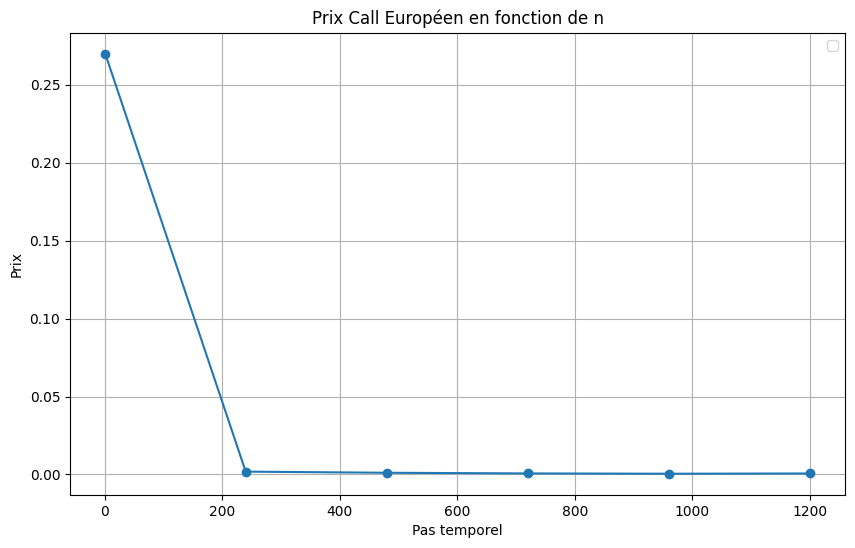

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Définir les valeurs de n
n_values = np.linspace(1, 1200, 6, dtype=int)

# Définir les autres paramètres
K = 100
S_o = 94
truth = 5.8620
# Créer une figure
plt.figure(figsize=(10, 6))
R=[]
# Parcourir les valeurs de n
for n in n_values:
    P=transition_matrix(Q,1/n)
    arbre=arbre_recomb2(n,2)
    A1 = prix_call_europeen(K, S_o, n, 2, 0.2, 1, L1, L2, L3, L4, P)[:,0][n*2][0]
    R.append(A1)
plt.plot(n_values, np.abs(truth-np.array(R)), marker = "o")
# Ajouter des labels et une légende
plt.xlabel('Pas temporel')
plt.ylabel('Prix')
plt.title('Prix Call Européen en fonction de n')
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.show()
